# Numerical simulation for DB-QITE on 2d Heisenberg model

### View paper at

https://arxiv.org/abs/2412.04554


# 1. Initialization

In [1]:
from qrisp.operators import X, Y, Z

import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

import pickle

def save_data(data, filename):  
    # Open a file for writing
    with open(filename+'.pickle', 'wb') as file:
        # Write the object to the file
        pickle.dump(data, file)

def load_data(filename):
    with open(filename+'.pickle', 'rb') as file:
        # Load the object from the file
        data = pickle.load(file)
    return data

def compute_moments(psi, H):
    E = (psi.conj().T @ H.dot(psi)).real
    S = (psi.conj().T @ (H @ H).dot(psi)).real
    return E, S, S - E**2

def run_param_rc(fontsize = 30):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = "serif"
        plt.rcParams['font.serif'] = "cm"

## 1.1 Define the input Hamiltonian

[top](#Contents) 

In [2]:
def create_heisenberg_hamiltonian(G):
    H = sum(X(i)*X(j)+Y(i)*Y(j)+Z(i)*Z(j) for (i,j) in G.edges())
    return H

def generate_2D_cluster_graph(N):
       list_horizontal = [[l*N+k,l*N+k+1] for k in range(N-1) for l in range(N)]
       list_vertical = [[l*N+k,l*N+k+N] for k in range(N) for l in range(N-1)]
       coupling_list = list_horizontal+list_vertical
       graph = nx.Graph()
       graph.add_edges_from(coupling_list)
       #pos = {l*N+k:[k,-l] for k in range(N) for l in range(N)}
       return graph#, pos

def calculate_spectra(L):
    G = generate_2D_cluster_graph(L)

    H = create_heisenberg_hamiltonian(G)

    M = H.to_sparse_matrix()
    eigenvalues, eigenvectors = eigsh(M, k=2, which='SA')
    return eigenvalues, eigenvectors

x_val=list(range(3,5))

spectra = dict()
for L in x_val:
    spectra[L] = calculate_spectra(L) 

E0_val = dict()
E1_val = dict()
E0_vec = dict()
E1_vec = dict()

for L in x_val:
    E0_val[L] = spectra[L][0][0]
    E1_val[L] = spectra[L][0][1]

    E0_vec[L] = spectra[L][1][:,0]
    E1_vec[L] = spectra[L][1][:,1]

## Plot lowest energy eigenvalues

Degenerate ground state for $L=3$. In this case, fidelites in plots below are might not be meaningful!

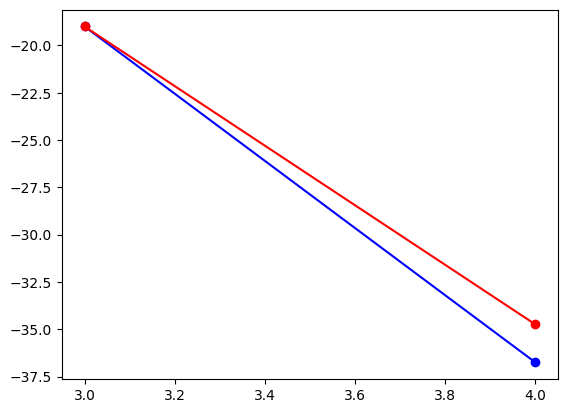

In [3]:
plt.plot(x_val, list(E0_val.values()), color='blue', marker='o', linestyle='solid')
plt.plot(x_val, list(E1_val.values()), color='red', marker='o', linestyle='solid')

## 1.2 Load data of previous simulations

[top](#Contents) 

In [4]:
# Load data (transpilation to {CZ,U3}), 2 steps 2nd order Trotterization, Singlet + HVA
#results_3 = load_data('data/benchmarks_2d_L=3_s=2_07-15-13') 
#results_4 = load_data('data/benchmarks_2d_L=4_s=2_07-15-14')

# Load data (transpilation to {CZ,U3}), 1 steps 2nd order Trotterization, Singlet + HVA
results_3 = load_data('data/benchmarks_2d_L=3_s=1_07-15-16') 
results_4 = load_data('data/benchmarks_2d_L=4_s=1_07-15-16')

results_QITE = dict()
results_QITE[3] = results_3
results_QITE[4] = results_4

# Visualize fidelity $F_k$ in DB-QITE

[top](#Contents) 

In [5]:
L=4
psi = E0_vec[L] # ground state
states = results_QITE[L][1]["statevectors"] # 0 Singlet, 1 HVA
fidelities = []
for phi in states:
    fidelities.append(np.abs(np.dot(psi.conj().transpose(),phi))**2)

fidelities

[np.float64(0.6642347651900701),
 np.float64(0.866316951347733),
 np.float64(0.9321438092060708),
 np.float64(0.9650418942762437)]

### 2.1 Generate plots for energies and fidelities

[top](#Contents) 

In [6]:
def generate_plots(ax1, L):
    
    lables_energies=[r"$E_k\ |$Singlet$\rangle$",r"$E_k\ |$HVA$\rangle$"]
    lables_fidelities=[r"$F_k\ |$Singlet$\rangle$",r"$F_k\ |$HVA$\rangle$"]
    alphas = [1.0, 0.6]
    markers = ['d','o']
    indices = [0,1] 
    steps = [0,1,2,3]

    results = results_QITE[L]

    ###############################################################################
    # SUBPLOT 1: Energy
    ###############################################################################

    # 1) Plot energies on the left y-axis
    for i,ind in enumerate(indices):
        #line1, = ax1.plot(results[ind]['evolution_times'], results[ind]['optimal_energies'], label=lables_energies[ind], color='blue', marker=markers[i], linestyle='solid', linewidth=2, zorder=3, alpha=alphas[i])
        line1, = ax1.plot(steps, results[ind]['optimal_energies'], label=lables_energies[ind], color='blue', marker=markers[i], linestyle='solid', linewidth=2, zorder=3, alpha=alphas[i])

    ax1.axhline(y=E0_val[L], color="red", linestyle=':', alpha=1.0)
    #ax1.axhline(y=E0_val[L]+0.1, color="orange", linestyle=':', alpha=0.8)
    ax1.axhline(y=E1_val[L], color="red", linestyle=':', alpha=0.6)

    ax1.text(
        0.2,           
        E0_val[L]+0.15,       
        r"$\lambda_0$",                          
        va="center",
        ha="left",
        color="red",
    )   

    ax1.text(
        0.2,           
        E1_val[L]+0.15,             
        r"$\lambda_1$",                           
        va="center",
        ha="left",
        color="red",
        alpha = 0.6
    )

    ax1.set_xlabel(r"Steps $k$")
    ax1.set_ylabel(r"Energy $E_k$")
    ax1.set_xticks(ticks = range(0, 6, 1))
    ax1.legend(loc="center right", fontsize=12)
    ax1.set_title(f"DB-QITE for $L={L}$")

    ###############################################################################
    # SUBPLOT 2: Fidelity
    ###############################################################################

    # 2) Create a twin axis for fluctuations
    axF = ax1.twinx()

    fidelities = dict()
    for ind in indices:
        # Calculate fidelities
        psi = E0_vec[L] # ground state
        states = results[ind]["statevectors"]
        fidelities_ = []
        for phi in states:
            fidelities_.append(np.abs(np.dot(psi.conj().transpose(),phi))**2)
        fidelities[ind] = fidelities_

    # 1) Plot energies on the left y-axis
    for i,ind in enumerate(indices):
        #line1, = axF.plot(results[ind]['evolution_times'], fidelities[ind], label=lables_fidelities[ind], color='green', marker=markers[i], linestyle='solid', linewidth=2, zorder=3, alpha=alphas[i])
        line1, = axF.plot(steps, fidelities[ind], label=lables_fidelities[ind], color='green', marker=markers[i], linestyle='solid', linewidth=2, zorder=3, alpha=alphas[i])

    axF.axhline(y=1, color="orange", linestyle=':', alpha=1.0)
    axF.axhline(y=0.975, color="orange", linestyle=':', alpha=0.8)
    axF.axhline(y=0.95, color="orange", linestyle=':', alpha=0.6)

    axF.set_ylabel(r"Fidelity $F_k$")

    ###############################################################################

    # 3) Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = axF.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right", ncol=1, fontsize=12)


### 2.2 Produce plot for $L=4$

[top](#Contents) 

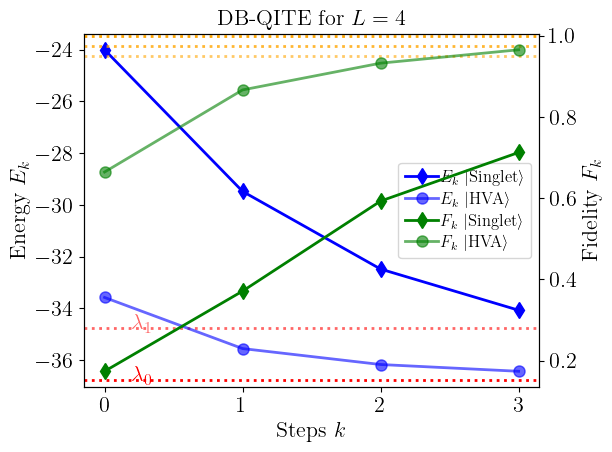

In [7]:
run_param_rc(16)

fig, ax1 = plt.subplots()
generate_plots(ax1, 4)
plt.tight_layout()
plt.show()

# Circuit gate counts of DB-QITE

In [8]:
def generate_circuit_plots_QITE(axC, L, init_type='HVA'):

    ###############################################################################
    # SUBPLOT 3: Circuit data 
    ###############################################################################
    results = results_QITE[L]

    steps = [0,1,2,3]

    # Singlet
    u_count_S = np.array([results[0]["circuit_data"][0][k]['u3'] for k in steps])
    cz_count_S = np.array([results[0]["circuit_data"][0][k]['cz'] for k in steps])
    depth_S = np.array([results[0]["circuit_data"][2][k] for k in steps])

    # HVA
    u_count_HVA = np.array([results[1]["circuit_data"][0][k]['u3'] for k in steps])
    cz_count_HVA = np.array([results[1]["circuit_data"][0][k]['cz'] for k in steps])
    depth_HVA = np.array([results[1]["circuit_data"][2][k] for k in steps])

    scaling = 1000

    if init_type=='Singlet':
        axC.plot(steps, u_count_S/scaling, marker='d', color='#1f77b4', alpha=1.0, label='U3 count')
        axC.plot(steps, cz_count_S/scaling, marker='o', color='#ff7f0e', alpha=1.0, label='CZ count')
        axC.plot(steps, depth_S/scaling, marker='s', color='#2ca02c', alpha=1.0, label='Depth')

        axC.plot(steps, u_count_HVA/scaling, color='#1f77b4', marker='d', alpha=0.6, linestyle='dashed') 
        axC.plot(steps, cz_count_HVA/scaling, color='#ff7f0e', marker='o', alpha=0.6, linestyle='dashed') 
        axC.plot(steps, depth_HVA/scaling, color='#2ca02c', marker='s', alpha=0.6, linestyle='dashed')    
    else:
        axC.plot(steps, u_count_HVA/scaling, marker='d', color='#1f77b4', alpha=1.0, label='U3 count')
        axC.plot(steps, cz_count_HVA/scaling, marker='o', color='#ff7f0e', alpha=1.0, label='CZ count')
        axC.plot(steps, depth_HVA/scaling, marker='s', color='#2ca02c', alpha=1.0, label='Depth')

        axC.plot(steps, u_count_S/scaling, color='#1f77b4', marker='d', alpha=0.6, linestyle='dashed') 
        axC.plot(steps, cz_count_S/scaling, color='#ff7f0e', marker='o', alpha=0.6, linestyle='dashed') 
        axC.plot(steps, depth_S/scaling, color='#2ca02c', marker='s', alpha=0.6, linestyle='dashed')        

    axC.set_xlabel(r"Steps $k$")
    axC.set_ylabel("Counts in thousands")
    axC.set_xticks(ticks = range(0, len(steps), 1))

    axC.legend(loc="upper left", ncols=3, fontsize=15)
    axC.set_title(f"DB-QITE for $L={L}$")

    ###############################################################################
    # Inset table: circuit data GC
    ###############################################################################

    psi = E0_vec[L] # ground state
    if init_type=='Singlet':
        states = results[0]["statevectors"] # 0 Singlet, 1 HVA
    else:
        states = results[1]["statevectors"] # 0 Singlet, 1 HVA
    fidelities = []
    for phi in states:
        fidelities.append(np.round(np.abs(np.dot(psi.conj().transpose(),phi))**2,3))

    # Data for the table
    rows = [' 0 ', '1', '2', '3']
    columns = (r'$k$','U3', 'CZ', 'Depth', r'$|\langle \Psi_k | \lambda_0 \rangle |^2$')
    if init_type=='Singlet':
        cell_text = [[rows[i], u_count_S[i], cz_count_S[i], depth_S[i], fidelities[i]] for i in range(len(steps))]
    else:
        cell_text = [[rows[i], u_count_HVA[i], cz_count_HVA[i], depth_HVA[i], fidelities[i]] for i in range(len(steps))]

    # Adjust column widths
    col_widths = [0.05, 0.1, 0.1, 0.1, 0.1]  # First column is wider

    # Add a table at the bottom of the axes
    tableC = axC.table(cellText=cell_text,
                        colLabels=columns,
                        loc='center left',
                        colWidths=col_widths)
    tableC.auto_set_font_size(False)
    tableC.set_fontsize(12)
    tableC.scale(1.5, 1.5)  # Adjust the scaling as needed


### 2.2 Produce plot for $L=4$

[top](#Contents) 

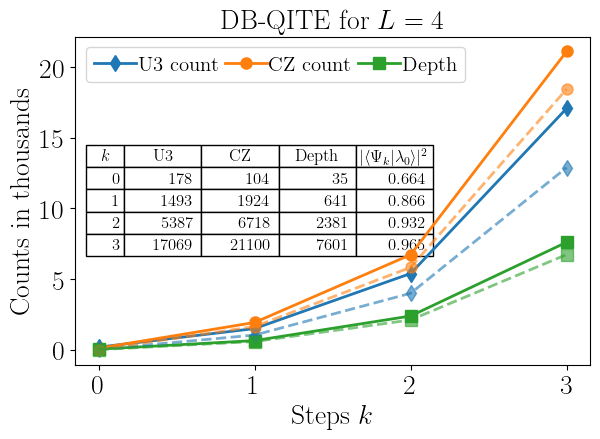

In [9]:
run_param_rc(20)

fig, ax1 = plt.subplots()
init_type = "HVA"
generate_circuit_plots_QITE(ax1, 4, init_type)
plt.tight_layout()
plt.show()